---
# 1 - IMPORTS

### 1.1 - SETUP PROJECT

In [5]:
# IMPORTS

# Standard libraries
import sys
import importlib
import pandas as pd
import numpy as np

# Third-party
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Add "../src/utilities" to sys.path for custom utilities
sys.path.append("../src/utilities")  # Ensure src/ is in path

# Import utils (reload to pick up latest edits)
try:
    import utils
    importlib.reload(utils)   # Ensures latest version is loaded
except ImportError as e:
    raise ImportError(f"Could not import utils module: {e}")

---
# 2 - DATASET LOAD

### 2.1 - LOADING

Here I am loading back in the X sets (with the addition of the newly engineered features) and y sets (which have not undergone any modifications since the splitting stage).

In [6]:
# Load data
X_train = pd.read_pickle("../data/interim/04_X_train.pkl")
X_test  = pd.read_pickle("../data/interim/04_X_test.pkl")
y_train = pd.read_pickle("../data/interim/04_y_train.pkl").squeeze()
y_test  = pd.read_pickle("../data/interim/04_y_test.pkl").squeeze()

---
# 3 - PREPROCESSING

In [8]:
# Identify column types
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print(num_cols)
print(cat_cols)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

['app_order', 'prev_grade', 'admission_grade', 'age_at_enrollment', 'sem1_credited', 'sem1_enrolled', 'sem1_evals', 'sem1_approved', 'sem1_grade', 'sem1_noevals', 'unemp_rate', 'inflation', 'gdp']
['marital', 'app_mode', 'course', 'att_mode', 'prev_qual', 'nationality', 'mother_qual', 'father_qual', 'mothers_occupation', 'fathers_occupation', 'displaced', 'educational_special_needs', 'debtor', 'tuition_fees_up_to_date', 'gender', 'scholarship_holder', 'international']


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Logistic Regression
log_reg = Pipeline([
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Random Forest
rf = Pipeline([
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"))
])


# 3 - MODELING


=== Logistic Regression ===
              precision    recall  f1-score   support

     Dropout      0.797     0.703     0.747       269
    Enrolled      0.373     0.553     0.446       159
    Graduate      0.839     0.753     0.794       442

    accuracy                          0.701       870
   macro avg      0.670     0.670     0.662       870
weighted avg      0.741     0.701     0.716       870


=== Random Forest ===
              precision    recall  f1-score   support

     Dropout      0.783     0.740     0.761       269
    Enrolled      0.494     0.258     0.339       159
    Graduate      0.760     0.916     0.831       442

    accuracy                          0.741       870
   macro avg      0.679     0.638     0.644       870
weighted avg      0.719     0.741     0.719       870



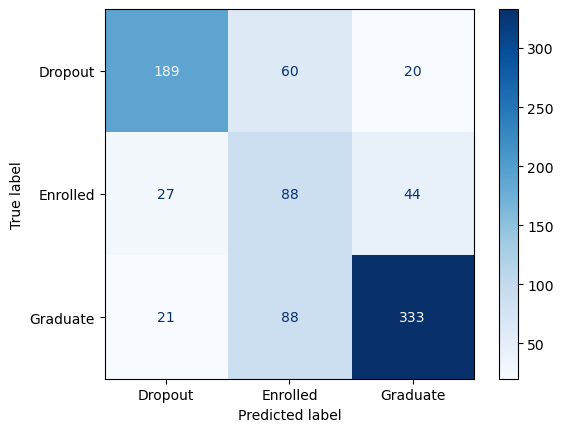

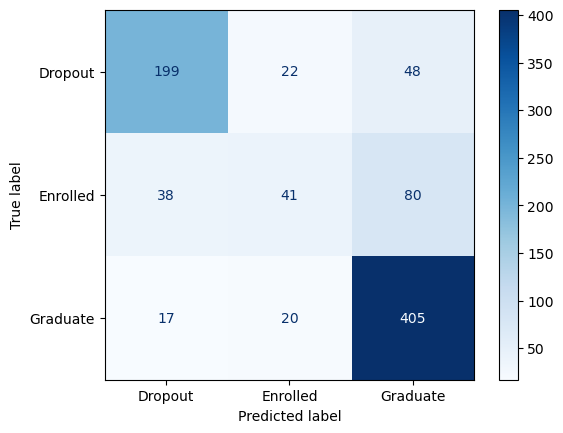

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")


In [15]:
from sklearn.model_selection import GridSearchCV

# Example for Random Forest
param_grid = {
    "clf__n_estimators": [100, 200, 500],
    "clf__max_depth": [None, 10, 20]
}

grid_rf = GridSearchCV(rf, param_grid, cv=3, scoring="f1_macro", n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best params:", grid_rf.best_params_)
print("Best CV score:", grid_rf.best_score_)


Best params: {'clf__max_depth': 10, 'clf__n_estimators': 100}
Best CV score: 0.6875484298119977


Classes: ['Dropout', 'Enrolled', 'Graduate']
Macro-averaged ROC AUC (OvR): 0.847


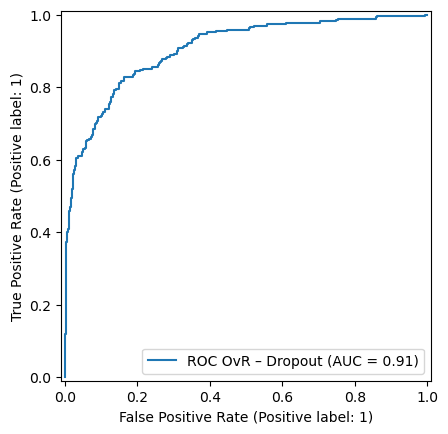

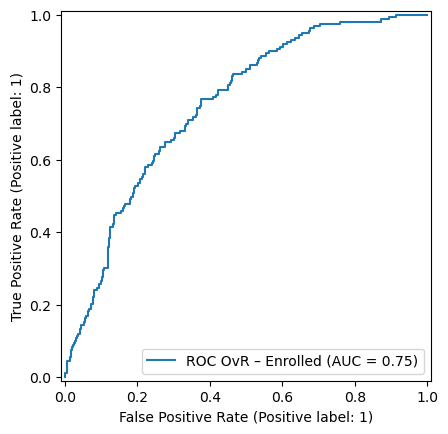

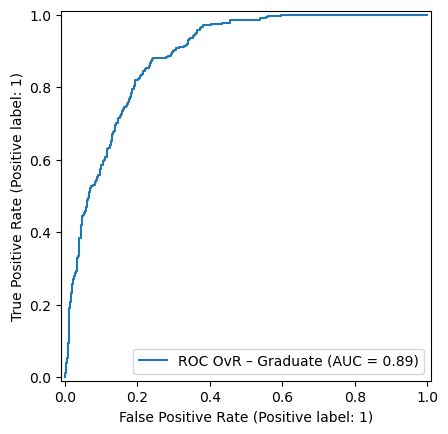

In [14]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score

# 1) Get class order from the fitted pipeline
class_order = list(best_rf.classes_)   # e.g. ['Dropout','Enrolled','Graduate']
print("Classes:", class_order)

# 2) Predict class probabilities on test set (one column per class)
proba = best_rf.predict_proba(X_test)

# 3) Plot OvR ROC curves (one vs rest)
for i, cls in enumerate(class_order):
    # binary ground truth: 1 for this class, 0 for others
    y_true_bin = (y_test == cls).astype(int)
    y_score = proba[:, i]
    RocCurveDisplay.from_predictions(y_true=y_true_bin, y_pred=y_score, name=f"ROC OvR – {cls}")

# 4) Macro-averaged ROC AUC (single number summary across classes)
auc_macro_ovr = roc_auc_score(y_test, proba, multi_class="ovr", average="macro")
print(f"Macro-averaged ROC AUC (OvR): {auc_macro_ovr:.3f}")


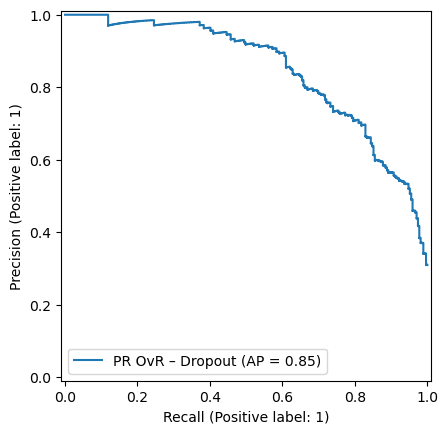

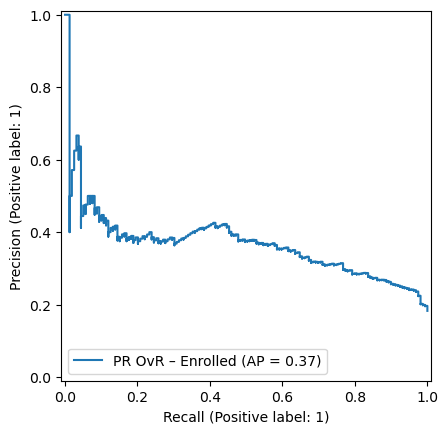

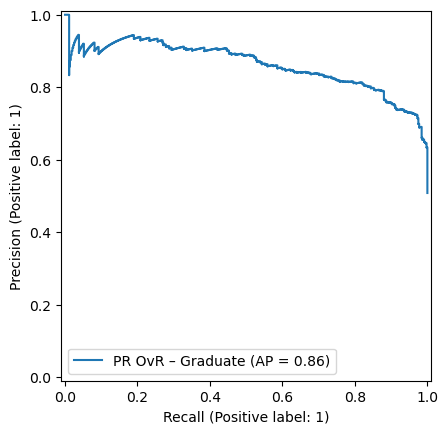

In [16]:
# Precision–Recall curves (one vs rest)
for i, cls in enumerate(class_order):
    y_true_bin = (y_test == cls).astype(int)
    y_score = proba[:, i]
    PrecisionRecallDisplay.from_predictions(y_true=y_true_bin, y_pred=y_score, name=f"PR OvR – {cls}")


**Model Comparison**  
- Logistic Regression: interpretable, but weaker at capturing complex interactions.  
- Random Forest: better performance, robust to multicollinearity, but less interpretable.  

**Observations**  
- Class imbalance required `class_weight="balanced"`.  
- Random Forest handled categorical variables well after one-hot encoding.  
- Logistic Regression highlighted which features are most linearly associated with dropout risk.  

**Trade-offs**  
- Random Forest gives stronger accuracy and F1, but is less transparent.  
- Logistic Regression is easier to interpret, useful for communicating key risk drivers to stakeholders.  

**Next Steps**  
- Try advanced tuning (RandomizedSearchCV, Bayesian search).  
- Apply feature importance / SHAP to explain predictions.  
- Consider ethical implications: false negatives (missing at-risk students) may cause harm.  
